In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [5]:
df = pd.read_csv("..//Data-science//data//breast_cancer_imbalance.csv")

# 分類モデルでのデータ分割では，StratifiedKFoldを使う

skf = StratifiedKFold(n_splits = 5, shuffle = True)
df["fold"] = -1
for fold, (train_idx, test_idx) in enumerate(skf.split(X = df, y = df["target"])):
    df.loc[test_idx, "fold"] = fold
print(df["fold"].value_counts())

0    80
1    80
2    80
3    80
4    80
Name: fold, dtype: int64


In [6]:
fold = 0
train = df.loc[df["fold"] != fold].copy()
test = df.loc[df["fold"] == fold].copy()
print(train.shape, test.shape)

feat_cols = train.drop(columns = ["fold", "target"]).columns.tolist()
print(feat_cols)

# 訓練データとテストデータに分割する
X_train = train[feat_cols]
X_test = test[feat_cols]
y_train = train["target"]
y_test = test["target"]

(320, 32) (80, 32)
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


In [7]:
# データセットを生成する
trains = lgb.Dataset(X_train, y_train, feature_name='auto')
evals = lgb.Dataset(X_test, y_test, feature_name='auto')

In [25]:
params = {
    'objective': 'binary',
    'metric': 'auc',
}

results_dict = {}

In [26]:
model = lgb.train(
    params,
    trains,
    num_boost_round=1000,
    early_stopping_rounds=50,
    valid_sets=[trains, evals],
    evals_result=results_dict
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 283, number of negative: 37
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3192
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884375 -> initscore=2.034529
[LightGBM] [Info] Start training from score 2.034529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's auc: 0.986868	valid_1's auc: 0.85133
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's auc: 0.993792	valid_1's auc: 0.921753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's auc: 0.994747	valid_1's au

In [27]:
pred = model.predict(X_test, num_iteration=model.best_iteration)

In [28]:
results_dict

{'training': OrderedDict([('auc',
               [0.9868684939356317,
                0.9937923789513895,
                0.9947473975742527,
                0.9961321745774042,
                0.9956546652659727,
                0.9966096838888359,
                0.9968006876134085,
                0.9973736987871263,
                0.9989494795148506,
                0.9992359851017095,
                0.9993314869639958,
                0.9997134944131411,
                0.9997134944131411,
                0.9999044981377136,
                0.9999044981377136,
                0.9999044981377136,
                0.9999044981377136,
                0.9999044981377136,
                1.0,
                1.0,
                1.0,
                1.0,
                1.0,
                1.0,
                1.0,
                1.0,
                1.0,
                1.0,
                1.0,
                1.0,
                1.0,
                1.0,
                1.0,
   

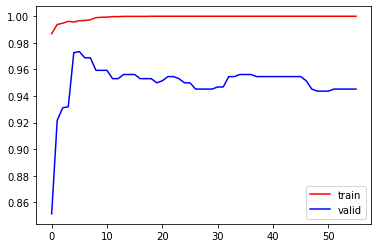

In [29]:
import matplotlib.pyplot as plt
plt.plot(results_dict["training"]["auc"], color = "red", label = "train")
plt.plot(results_dict["valid_1"]["auc"], color = "blue", label = "valid")
plt.legend()
plt.show()

In [20]:
# AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, pred)
print(auc)

0.9733959311424101


## ベイズ最適化

In [30]:
import optuna.integration.lightgbm as lgb_tune
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import KFold

In [45]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss'
}

results_dict = {}

In [36]:
best_params, history = {}, []

tuner_cv = lgb_tune.LightGBMTunerCV(
    params,
    trains,
    folds=KFold(n_splits=5),
    num_boost_round=1000,
    early_stopping_rounds=50
)

[I 2021-12-25 01:10:19,140] A new study created in memory with name: no-name-4c6ed148-95e7-42cc-a7ce-52ce581f3e13


In [37]:
best_params = tuner_cv.best_params
best_params

{'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'objective': 'binary',
 'metric': 'binary_logloss',
 'feature_pre_filter': False}

In [46]:
# 一度学習させると，再度データを初期化する必要がある
trains = lgb.Dataset(X_train, y_train, feature_name='auto')
evals = lgb.Dataset(X_test, y_test, feature_name='auto')

In [48]:
model_best = lgb.train(
    best_params,
    trains,
    num_boost_round=1000
)

[LightGBM] [Info] Number of positive: 283, number of negative: 37
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3192
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884375 -> initscore=2.034529
[LightGBM] [Info] Start training from score 2.034529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [49]:
pred_tune = model.predict(X_test)

In [50]:
# AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, pred)
print(auc)

0.9733959311424101
